# 2 - Introduction to Statistics: Correlation, fitting, regression, and interpolation/extrapolation

## 1. Correlation

First, let's import the libraries and data we'll need:

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

NBA_regular_2021 = pd.read_csv('../Data/NBA_2021-2022_stats_Regular.csv', engine='python', delimiter=';', encoding='latin-1')

### Correlation

Correlation shows how two variables are related. It tells us if they tend to increase or decrease together or 
move in opposite directions.

**Remember:** correlation does not mean causation! Just because two variables are related does not mean one causes the other


Let's look at the variables in our dataset. Are there any two you think might be associated?

In [51]:
print(np.asarray(NBA_regular_2021.columns))

['Rk' 'Player' 'Pos' 'Age' 'Tm' 'G' 'GS' 'MP' 'FG' 'FGA' 'FG%' '3P' '3PA'
 '3P%' '2P' '2PA' '2P%' 'eFG%' 'FT' 'FTA' 'FT%' 'ORB' 'DRB' 'TRB' 'AST'
 'STL' 'BLK' 'TOV' 'PF' 'PTS']


Consider the "MP" variable (minutes played). Before looking for correlations, it would be useful to understand what we can about the variable. Let's find the range, and have a look at a histogram of the distrubition in this variable

In [52]:
MP_min = np.min(NBA_regular_2021['MP'])
MP_max = np.max(NBA_regular_2021['MP'])
MP_Range = MP_max - MP_min

print("Min MP:      ", MP_min)
print("Max MP:      ", MP_max)
print("Range in MP: ", MP_Range)

Min MP:       1.0
Max MP:       43.5
Range in MP:  42.5


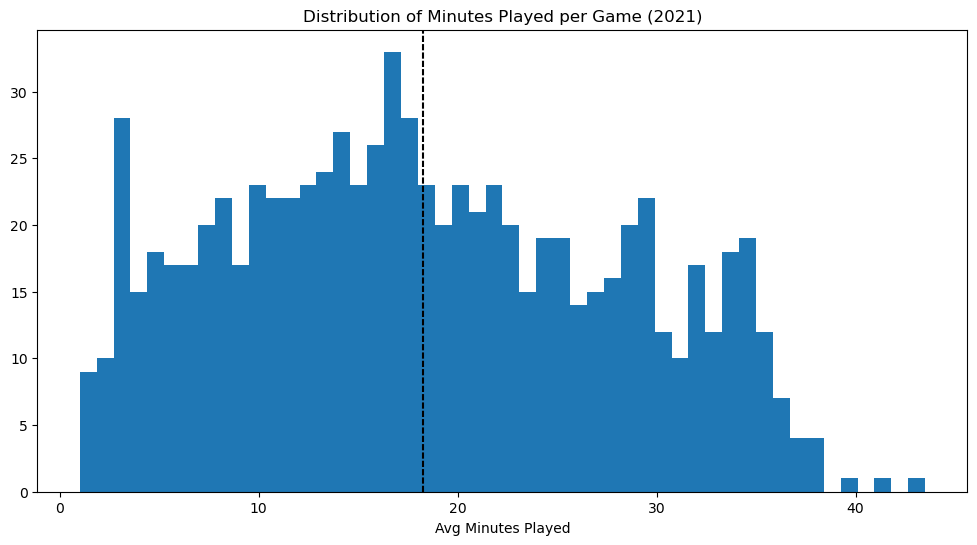

In [53]:
plt.figure(figsize=(12, 6))
plt.xlabel('Avg Minutes Played')
plt.title('Distribution of Minutes Played per Game (2021)')

MP_Average=np.mean(NBA_regular_2021['MP'])

plt.hist(NBA_regular_2021['MP'], bins=50)
plt.axvline(MP_Average, color='black', dashes=[3,1])
plt.show()

The distribution of games played looks close to normal, with a peak close to the average. There is another significant peak near 2-3 minutes played, which means that quite commonly, players only play 2-3 minutes per game (likely from substitutions for a short amount of time or to fulfill a specific role). 

Let's have a look at some potential relations between minutes played and other variables, starting with scatter plots of MP as the independent variable and some other stat as the dependent variable

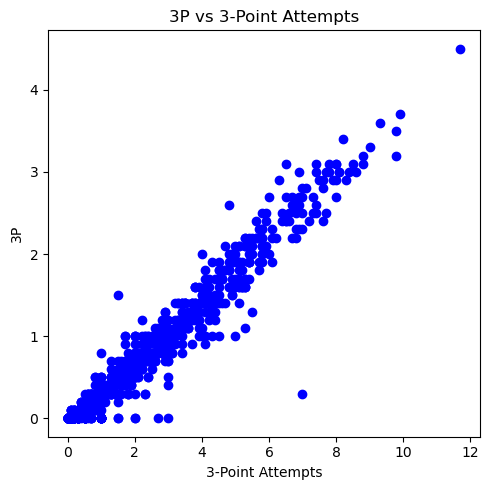

In [54]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# Plot positive correlation - 
independent_variable = "3PA"
dependent_variable = "3P"

axs.scatter(NBA_regular_2021[independent_variable], NBA_regular_2021[dependent_variable], color='blue')

axs.set_title('%s vs 3-Point Attempts' %dependent_variable)
axs.set_xlabel("3-Point Attempts")
axs.set_ylabel(dependent_variable)

plt.tight_layout()
plt.show()

What do you note about the connection between the dependent variable and minutes played?

What kind of correlation is there? 

If there exists a correlation, is it linear?

### Pearson correlation coefficient

How strongly correlated are the number of 3-Pointers and the 3-Point Attempts? The Pearson correlation coefficient will give us a good idea. This coefficient ranges from -1 to 1 **($-1 < R_P < 1$)**, with -1 meaning the two variables are as anti-correlated as possible (negative correlation), or as correlated as possible (positive correlation). It is calculated using the formula

## $R_P = \dfrac{\sum_i(x_i -\bar{x})(y_i -\bar{y})}{\sqrt{\sum_i(x_i -\bar{x})^2}\sqrt{\sum_i(y_i -\bar{y})^2}}$

We don't have to code this formula up, and can take advantage of numpy's corcoeff function to do this for us

In [55]:
# Compute Pearson correlation coefficient matrix
independent_variable = "3PA"
dependent_variable = "3P"
correlation_matrix = np.corrcoef(NBA_regular_2021[independent_variable], NBA_regular_2021[dependent_variable])

# Extract the coefficient
R_Pearson = correlation_matrix[0, 1]

print("Pearson correlation coefficient: ", R_Pearson)

Pearson correlation coefficient:  0.9698269645583638


What does this value of the Pearson correlation coefficient tell us? 

### 🔍 EXERCISE 1: Change the dependent variable to another stat you think might be interesting. Show the distribution of the stat, and the scatter between this stat and 3-Point Attempts. 3PA. Is there a potential relationship between 3-Point Attempts and this stat?

In [56]:
FG_min = np.min(NBA_regular_2021['FG'])
FG_max = np.max(NBA_regular_2021['FG'])
FG_Range = FG_max - FG_min

print("Min FG:      ", FG_min)
print("Max FG:      ", FG_max)
print("Range in FG: ", FG_Range)

Min FG:       0.0
Max FG:       11.4
Range in FG:  11.4


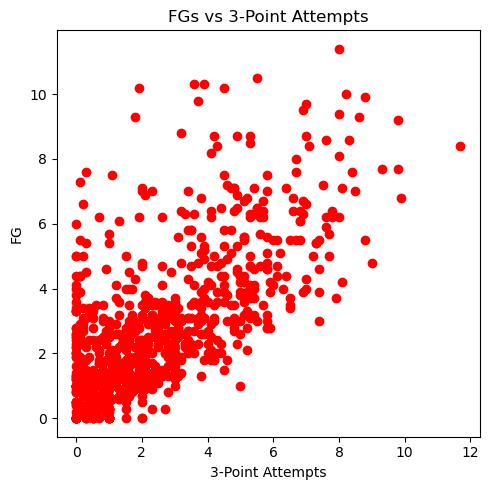

In [57]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# Plot positive correlation - 
independent_variable = "3PA"
dependent_variable = "FG"

axs.scatter(NBA_regular_2021[independent_variable], NBA_regular_2021[dependent_variable], color='red')

axs.set_title('FGs vs 3-Point Attempts')
axs.set_xlabel("3-Point Attempts")
axs.set_ylabel(dependent_variable)

plt.tight_layout()
plt.show()

In [58]:
# Compute Pearson correlation coefficient matrix
independent_variable = "3PA"
dependent_variable = "FG"
correlation_matrix = np.corrcoef(NBA_regular_2021[independent_variable], NBA_regular_2021[dependent_variable])

# Extract the coefficient
R_Pearson = correlation_matrix[0, 1]

print("Pearson correlation coefficient: ", R_Pearson)

Pearson correlation coefficient:  0.6800757353053527


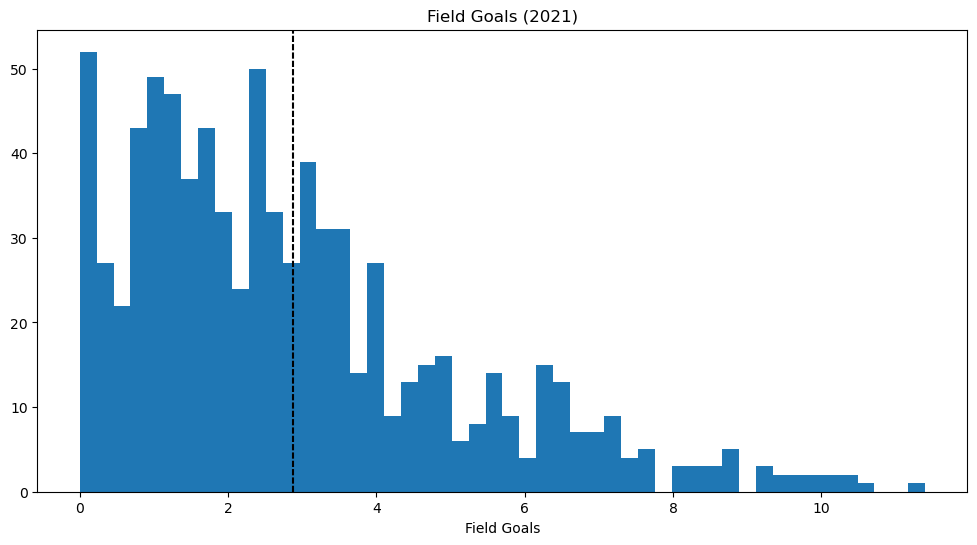

In [59]:
plt.figure(figsize=(12, 6))
plt.xlabel('Field Goals')
plt.title('Field Goals (2021)')

MP_Average=np.mean(NBA_regular_2021['FG'])

plt.hist(NBA_regular_2021['FG'], bins=50)
plt.axvline(MP_Average, color='black', dashes=[3,1])
plt.show()

### 🔍 EXERCISE 2: Find the Pearson correlation coefficient between the stat you chose and 3PA. Is there any kind of correlation between the two variables? If there is a correlation, is it weak or strong?

### Looking for correlations in your dataset

Because there are so many variables we could seek relationships for, let's try to automate the exploration of possible relationships between minutes played and other variables. Below we make a nested loop (over indices i and j) to plot all of the scatters for a given independent variable.

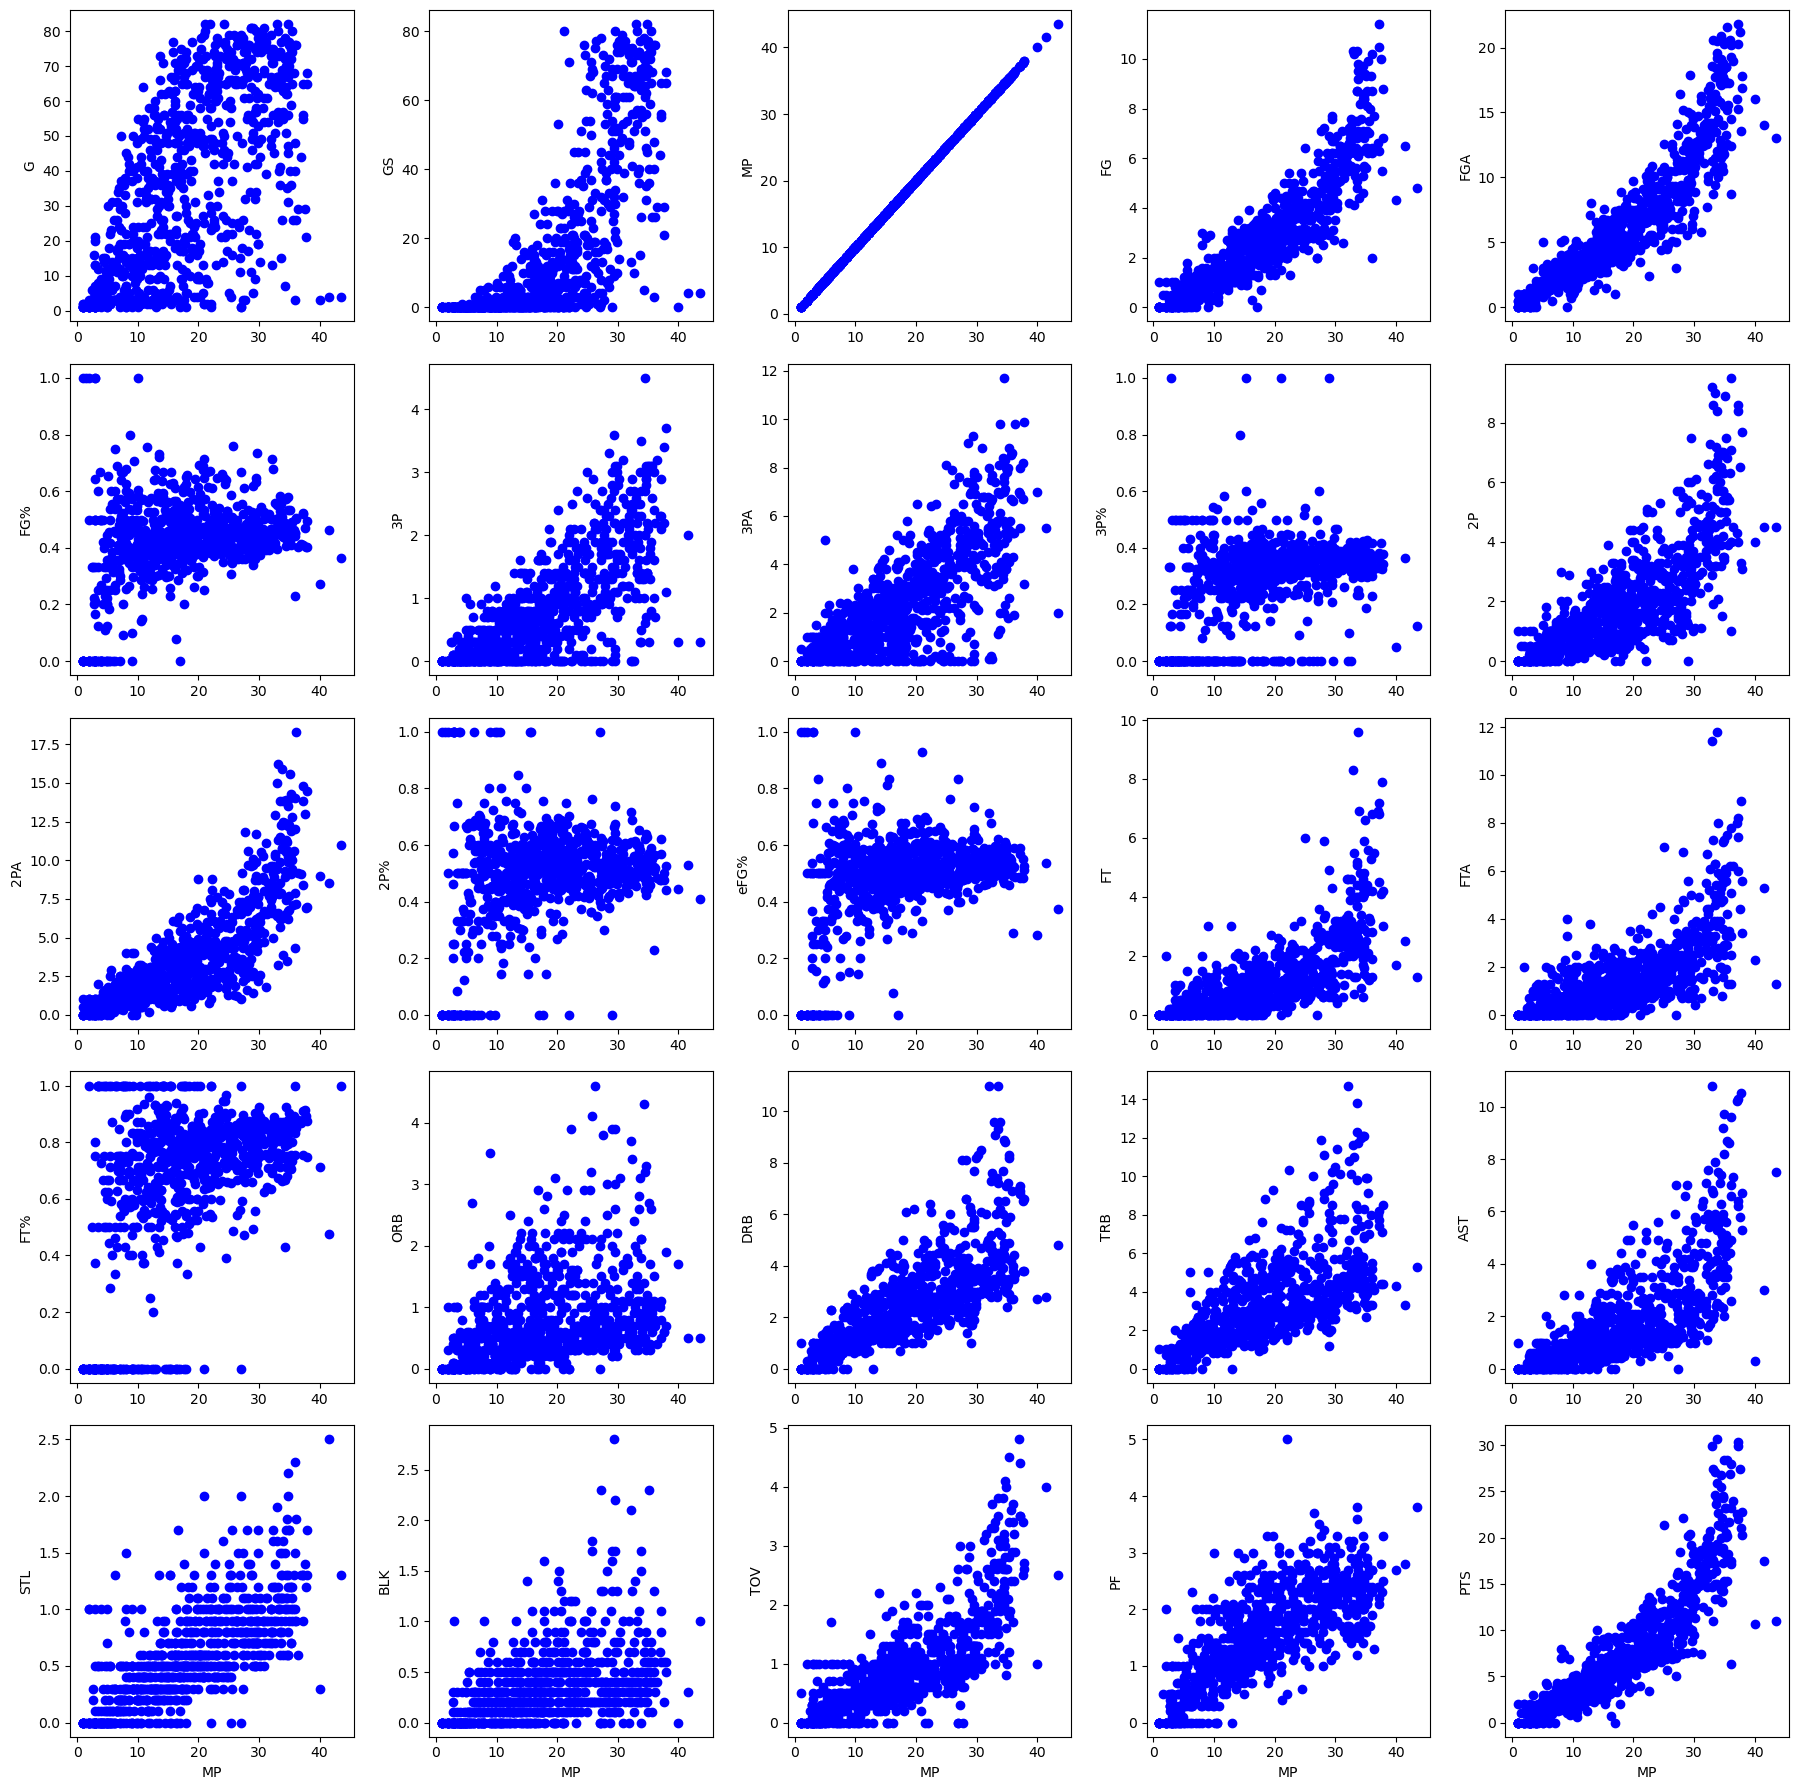

In [60]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(5, 5, figsize=(18, 18))

free_index=5
independent_var="MP"
for i in range(0, 5):
    for j in range(0, 5):
        dependent_variable = "%s"%NBA_regular_2021.columns[free_index]
        axs[i][j].scatter(NBA_regular_2021[independent_var], NBA_regular_2021[dependent_variable], color='blue')
        axs[i][j].set_ylabel(dependent_variable)
        free_index+=1
        if(i==4):
            axs[i][j].set_xlabel(independent_var)

#axs.set_xscale('log')
#axs.set_yscale('log')

#axs.set_ylim([1e-1, 1e0])
#axs.set_xlim([1e-1, 1e0])

#potential correlations - 3P%/MP, 3P%/2P%, 3P%/eFG%, 3P%/FT%, 3P%/PF, 3P%/PTS
#potential correlations - G/MP, G/FG%, G/2P%, G/eFG%, G/PF, G/PTS
#potential correlations - GS/MP, GS/PF, GS/PTS
#potential correlations - MP/FG, MP/FGA, MP/FG%, MP/3P%, MP/2P%, MP/eFG%, MP/DRB, MP/TRB, MP/STL, MP/TOV, MP/PF, MP/PTS
#potential correlations - FG/FG%, FG/2P%, FG/eFG%, FG/DRB, FG/TRB, FG/STL, FG/TOV, FG/PF, FG/PTS
#potential correlations - FG%/2P, FG%/3PA, FG%/2PA, FG%/FT%, FG%/ORB, FG%/PF
#potential correlations - 
#potential correlations - 
#potential correlations - 

plt.tight_layout()
plt.show()

Which scatters pop out to your eye?

Are all potential correlations linear? If not, what other kinds of relationships are there?

## 2. Linear regression

Let's look at another potential correlation, this time between minutes played (MP) and personal fouls (PF), which appear to have a linear correlation. Let's try to fit this scatter with a linear trend. 

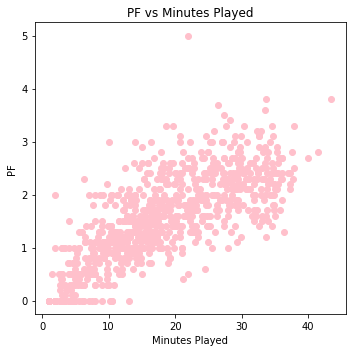

In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# Plot positive correlation - 
independent_variable = "MP"
dependent_variable = "PF"

axs.scatter(NBA_regular_2021[independent_variable], NBA_regular_2021[dependent_variable], color='pink')

axs.set_title('%s vs Minutes Played' %dependent_variable)
axs.set_xlabel("Minutes Played")
axs.set_ylabel(dependent_variable)

plt.tight_layout()
plt.show()

Recall, the equation of a line is

## $ y=mx+b $

and we can find the quantities corresponding to that line using the following equations:

## $ m = \dfrac{\sum_i (x_i - \bar{x})(y_i - \bar{y})}{\sum_i(x_i - \bar{x})^2} $
## $ b = \bar{y} - m \bar{x} $

where 

**$\bar{x} = $ average value for independent variable**

**$\bar{y} = $ average value for dependent variable**

**$ m = $ slope**

**$ b = $ y-intercept**

Thankfully we don't have to code these equation up ourselves and can use python libraries to do the linear regression for us. Below we use numpy to find the linear regression of two variables

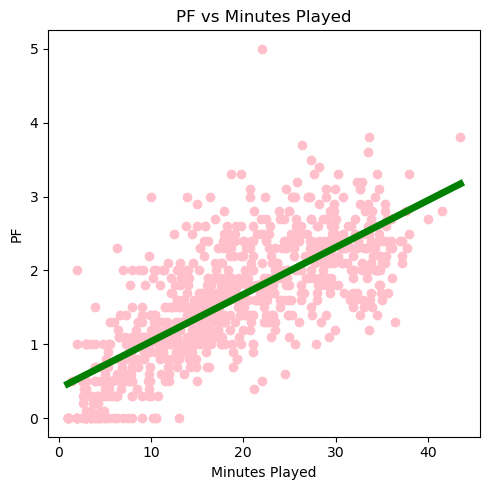

In [61]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# Plot positive correlation - 
independent_variable = "MP"
dependent_variable = "PF"

# Fit a polynomial of degree 1 (linear)
#slope, y_intercept = np.polyfit(NBA_regular_2021[independent_variable], NBA_regular_2021[dependent_variable], 1)
    
# Calculate predicted values y = m* x + b
x_array = np.array(NBA_regular_2021[independent_variable]).reshape(-1, 1)
y_array = np.array(NBA_regular_2021[dependent_variable])
model = LinearRegression()
model.fit(x_array, y_array)
    
# Calculate predicted values
slope = model.coef_[0]
y_intercept = model.intercept_
#y_fit = model.predict(NBA_regular_2021[independent_variable])
x_fit_linear = np.linspace(np.min(x_array), np.max(x_array), 100)
y_fit_linear = slope * x_fit_linear + y_intercept

# Calculate R-squared
#r_squared = model.score(x_array, y_array)
#slope = 
#y_fit = slope * NBA_regular_2021[independent_variable] + y_intercept
    
# Calculate R-squared
#correlation_matrix = np.corrcoef(NBA_regular_2021[independent_variable], NBA_regular_2021[dependent_variable])
#correlation_xy = correlation_matrix[0, 1]
#r_squared = correlation_xy**2
    
axs.scatter(NBA_regular_2021[independent_variable], NBA_regular_2021[dependent_variable], color='pink')
axs.plot(x_fit_linear, y_fit_linear, color='green', linewidth=5)

axs.set_title('%s vs Minutes Played' %dependent_variable)
axs.set_xlabel("Minutes Played")
axs.set_ylabel(dependent_variable)

plt.tight_layout()
plt.show()

### 🔍 EXERCISE 3: Given the line of best fit for the data above, find the estimated number of personal fouls for an arbitrary number of minutes played per game:
#### a. within the range of the Minutes Played data (interpolation)
#### b. outside of the range of the Minutes Played data (extrapolation)

In [68]:
print(slope, y_intercept)
# minutes played = 0-40

#minutes_played = 60

0.5645558098519889 -2.4993959283494753


Slope: 0.0637
Y-Intercept: 0.4008
Estimated Personal Fouls (MP = 30): 2.31
Estimated Personal Fouls (MP = 60): 4.22


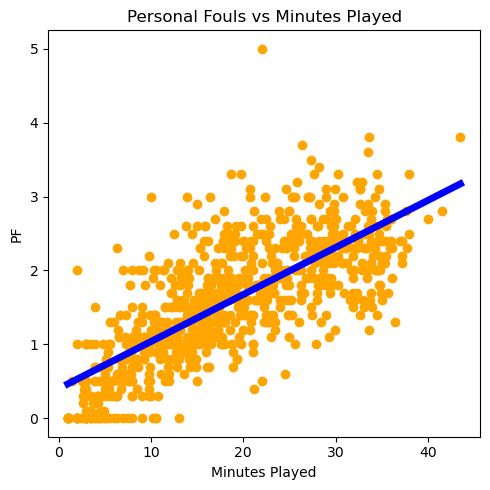

In [69]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# Plot positive correlation - 
independent_variable = "MP"
dependent_variable = "PF"

# Fit a polynomial of degree 1 (linear)
#slope, y_intercept = np.polyfit(NBA_regular_2021[independent_variable], NBA_regular_2021[dependent_variable], 1)
    
# Calculate predicted values y = m* x + b
x_array = np.array(NBA_regular_2021[independent_variable]).reshape(-1, 1)
y_array = np.array(NBA_regular_2021[dependent_variable])
model = LinearRegression()
model.fit(x_array, y_array)
    
# Calculate predicted values
slope = model.coef_[0]
y_intercept = model.intercept_
#y_fit = model.predict(NBA_regular_2021[independent_variable])
x_fit_linear = np.linspace(np.min(x_array), np.max(x_array), 100)
y_fit_linear = slope * x_fit_linear + y_intercept
print(f"Slope: {slope:.4f}")
print(f"Y-Intercept: {y_intercept:.4f}")
# Calculate R-squared
#r_squared = model.score(x_array, y_array)
#slope = 
#y_fit = slope * NBA_regular_2021[independent_variable] + y_intercept
    
# Calculate R-squared
#correlation_matrix = np.corrcoef(NBA_regular_2021[independent_variable], NBA_regular_2021[dependent_variable])
#correlation_xy = correlation_matrix[0, 1]
#r_squared = correlation_xy**2
minutes_played_interp = 30
estimated_fouls_interp = slope * minutes_played_interp + y_intercept
print(f"Estimated Personal Fouls (MP = 30): {estimated_fouls_interp:.2f}")    
axs.scatter(NBA_regular_2021[independent_variable], NBA_regular_2021[dependent_variable], color='orange')
axs.plot(x_fit_linear, y_fit_linear, color='blue', linewidth=5)

minutes_played_extra = 60
estimated_fouls_extra = slope * minutes_played_extra + y_intercept
print(f"Estimated Personal Fouls (MP = 60): {estimated_fouls_extra:.2f}")

axs.set_title('Personal Fouls vs Minutes Played')
axs.set_xlabel("Minutes Played")
axs.set_ylabel(dependent_variable)

plt.tight_layout()
plt.show()

## 3. Power law fitting

Let's have a look at a correlation that is not linear. For example, consider the relationship between Minutes Played and Points Scored. Recall, to fit a trend with a power law, we first take the logarithm of each dataset, and then fit the logarithms with a linear trend:

## $y=ax^c$
## $\log(y) = c\log(x) + \log(a)$

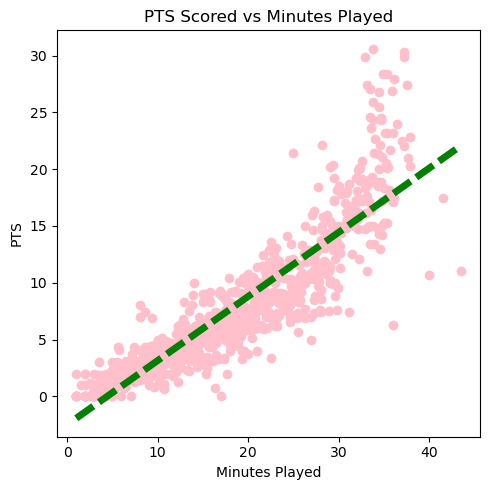

In [79]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# Plot positive correlation - 
independent_variable = "MP"
dependent_variable = "PTS"

# Calculate predicted values y = m* x + b
x_array = np.array(NBA_regular_2021[independent_variable]).reshape(-1, 1)
y_array = np.array(NBA_regular_2021[dependent_variable])
model = LinearRegression()
model.fit(x_array, y_array)
    
# Calculate predicted values
slope = model.coef_[0]
y_intercept = model.intercept_
#y_fit = model.predict(NBA_regular_2021[independent_variable])
x_fit_linear = np.linspace(np.min(x_array), np.max(x_array), 100)
y_fit_linear = slope * x_fit_linear + y_intercept

axs.scatter(x_array, y_array, color='pink')
axs.plot(x_fit_linear, y_fit_linear, color='green', linewidth=5, dashes=[3,1])

axs.set_title('%s Scored vs Minutes Played' %dependent_variable)
axs.set_xlabel("Minutes Played")
axs.set_ylabel(dependent_variable)

plt.tight_layout()
plt.show()

For lower values of Minutes Played (around 10-15 minutes) the relationship could be linear, but for higher values (past around 25 minutes), it clearly is not. Let's look at this relationship in the logarithmic space

C:\Users\rd7347\AppData\Local\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.19935854368697123 1.2246354419160024


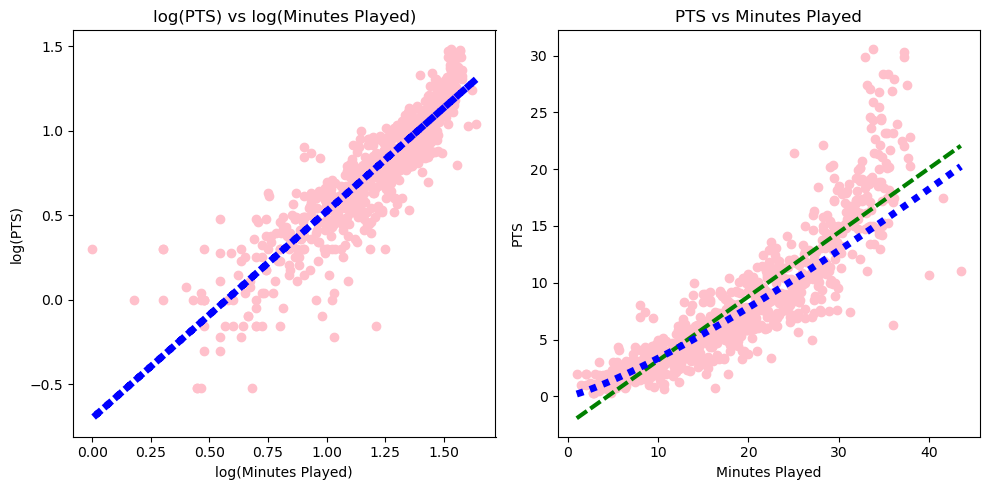

In [80]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot positive correlation - 
independent_variable = "MP"
dependent_variable = "PTS"

# Fit a polynomial of degree 1 (linear)
#slope, y_intercept = np.polyfit(NBA_regular_2021[independent_variable], NBA_regular_2021[dependent_variable], 1)
    
# Calculate predicted values y = m* x + b
log_x_array_raw = np.array(np.log10(NBA_regular_2021[independent_variable]))
log_y_array_raw = np.array(np.log10(NBA_regular_2021[dependent_variable]))

log_x_array = log_x_array_raw[np.isfinite(log_y_array_raw)].reshape(-1, 1)
log_y_array = log_y_array_raw[np.isfinite(log_y_array_raw)]

x_array = 10.**log_x_array
y_array = 10.**log_y_array
#print(log_x_array)
model = LinearRegression()
model.fit(log_x_array, log_y_array)
    
# Calculate predicted values
log_slope = model.coef_[0]
log_y_intercept = model.intercept_

powerlaw_coefficient = (10.**log_y_intercept)
powerlaw_power = log_slope
print(powerlaw_coefficient, powerlaw_power)

#y_fit = model.predict(NBA_regular_2021[independent_variable])
log_y_fit = log_slope * log_x_array + log_y_intercept
x_fit_powerlaw = np.linspace(np.min(x_array), np.max(x_array), 100)
y_fit_powerlaw = powerlaw_coefficient * x_fit_powerlaw**powerlaw_power
    
axs[0].scatter(log_x_array, log_y_array, color='pink')
axs[0].plot(log_x_array, log_y_fit, color='blue', linewidth=5, dashes=[1,1])

axs[0].set_title('log(%s) vs log(Minutes Played)' %dependent_variable)
axs[0].set_xlabel("log(Minutes Played)")
axs[0].set_ylabel("log(%s)"%dependent_variable)

axs[1].scatter(x_array, y_array, color='pink')
axs[1].plot(x_fit_linear, y_fit_linear, color='green', linewidth=3, dashes=[3,1])
axs[1].plot(x_fit_powerlaw, y_fit_powerlaw, color='blue', linewidth=5, dashes=[1,1])


axs[0].set_title('log(%s) vs log(Minutes Played)' %dependent_variable)
axs[0].set_xlabel("log(Minutes Played)")
axs[0].set_ylabel("log(%s)"%dependent_variable)

axs[1].set_title('%s vs Minutes Played' %dependent_variable)
axs[1].set_xlabel("Minutes Played")
axs[1].set_ylabel("%s"%dependent_variable)

plt.tight_layout()
plt.show()

## 4. Polynomial fitting

With polynomial fitting, we assume that the line that best fits the scatter is given by a function that looks like

## $ y = a_1 x + a_2x^2 + a_3x^3 + \cdots$
or, in other words
## $y = \sum_i a_ix^i$

Depending on the value of $i$ at which we stop the sum above, it can be a complicated procedure to find the polynomial fit. Thankfully there are python libraries that can do it for us in a couple of lines of code

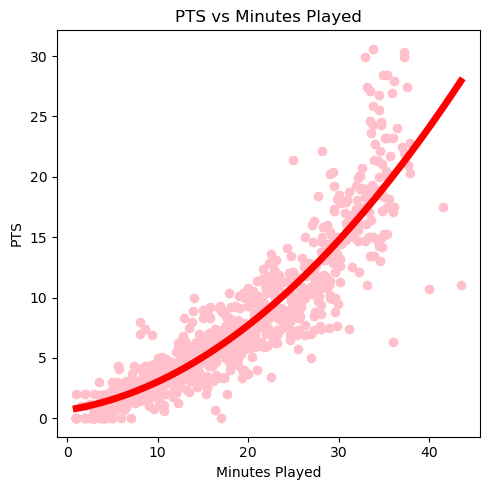

In [82]:

x_array = NBA_regular_2021[independent_variable]
y_array = NBA_regular_2021[dependent_variable]

# Fit a 2nd-degree polynomial
coeffs = np.polyfit(x_array, y_array, deg=2)

# Evaluate the polynomial
p = np.poly1d(coeffs)
x_fit = np.linspace(np.min(x_array), np.max(x_array), 500)
y_fit = p(x_fit)


# Calculate predicted values y = m* x + b
x_array = np.array(NBA_regular_2021[independent_variable]).reshape(-1, 1)
y_array = np.array(NBA_regular_2021[dependent_variable])
model = LinearRegression()
model.fit(x_array, y_array)
#make a new plot
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

axs.scatter(x_array, y_array, color='pink')
#axs.plot(x_fit_linear, y_fit_linear, color='green', linewidth=3, dashes=[3,1])
#axs.plot(x_fit_powerlaw, y_fit_powerlaw, color='blue', linewidth=3, dashes=[1,1])
axs.plot(x_fit, y_fit, color='red', linewidth=5)

axs.set_title('%s vs Minutes Played' %dependent_variable)
axs.set_xlabel("Minutes Played")
axs.set_ylabel(dependent_variable)

plt.tight_layout()
plt.show()

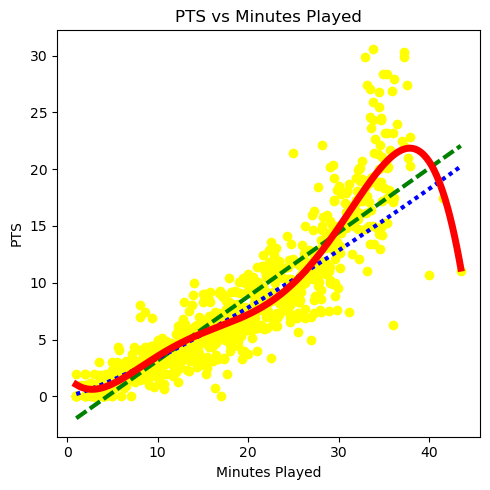

In [84]:
x_array = NBA_regular_2021[independent_variable]
y_array = NBA_regular_2021[dependent_variable]

# Fit a 5th-degree polynomial
coeffs = np.polyfit(x_array, y_array, deg=5)

# Evaluate the polynomial
p = np.poly1d(coeffs)
x_fit = np.linspace(np.min(x_array), np.max(x_array), 500)
y_fit = p(x_fit)

#make a new plot
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

axs.scatter(x_array, y_array, color='yellow')
axs.plot(x_fit_linear, y_fit_linear, color='green', linewidth=3, dashes=[3,1])
axs.plot(x_fit_powerlaw, y_fit_powerlaw, color='blue', linewidth=3, dashes=[1,1])
axs.plot(x_fit, y_fit, color='red', linewidth=5)

axs.set_title('%s vs Minutes Played' %dependent_variable)
axs.set_xlabel("Minutes Played")
axs.set_ylabel(dependent_variable)

plt.tight_layout()
plt.show()

### 🔍 EXERCISE 4: For the polynomial fit above, change the degree of the polynomial. What do you notice happens to the red line? What a potential issue with fitting data with two many polynomials?

### 🔍 EXERCISE 5: Given the lines of best fit  for the data above, find the estimated number of points scored for an arbitrary number of minutes played per game (stay within the range of the data) for the:
#### a. Linear regression
#### b. Power law fit
#### c. Polynomial

Which do you expect to be the most accurate? Why?

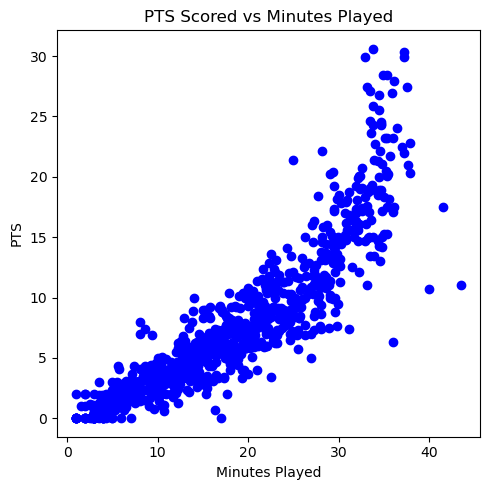

Estimated Points Scored(MP = 35): 17.26


In [90]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# Plot positive correlation - 
independent_variable = "MP"
dependent_variable = "PTS"

# Calculate predicted values y = m* x + b
x_array = np.array(NBA_regular_2021[independent_variable]).reshape(-1, 1)
y_array = np.array(NBA_regular_2021[dependent_variable])
model = LinearRegression()
model.fit(x_array, y_array)
    
# Calculate predicted values
slope = model.coef_[0]
y_intercept = model.intercept_
#y_fit = model.predict(NBA_regular_2021[independent_variable])
#x_fit_linear = np.linspace(np.min(x_array), np.max(x_array), 100)
#y_fit_linear = slope * x_fit_linear + y_intercept

axs.scatter(x_array, y_array, color='blue')
#axs.plot(x_fit_linear, y_fit_linear, color='green', linewidth=5, dashes=[3,1])

axs.set_title('%s Scored vs Minutes Played' %dependent_variable)
axs.set_xlabel("Minutes Played")
axs.set_ylabel(dependent_variable)

plt.tight_layout()
plt.show()

minutes_played_interp = 35
points_scored_interp = slope * minutes_played_interp + y_intercept
print(f"Estimated Points Scored(MP = 35): {points_scored_interp:.2f}")  

### 🔍 EXERCISE 6: Look for correlations in the dataset between an unexplored independent variable and all the other variables in the dataset. Show the scatter between this variable and all other variables. Choose one interesting relationship to further explore

### 🔍 EXERCISE 7: Looking at the relationship you've considered, find the Pearson correlation coefficient between the two variables. Are the two variables uncorrelated, weakly correlated, or strongly correlated?

### 🔍 EXERCISE 8: Find the linear regression and a polynomial fit. What is the equation of the line of best fit? What is the degree of the polynomial used to fit the data? What can you predict would happen if the model is extrapolated to values outside of your range?